In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"antongalysh","key":"bcffacf6d89ee637bc39b6676fe0c1b6"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download ikarus777/best-artworks-of-all-time
! unzip -qq best-artworks-of-all-time.zip
! rm -rf images
! mv resized artwork
! rm best-artworks-of-all-time.zip artists.csv

100% 2.29G/2.29G [01:50<00:00, 23.8MB/s]
100% 2.29G/2.29G [01:50<00:00, 22.3MB/s]


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras import layers

# Defining the global variables.
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32 # reduce if you get OOM Error
EPOCHS = 50
AUTOTUNE = tf.data.AUTOTUNE

## Data Downloading

In [4]:
def decode_and_resize(image_path):
    """Decodes and resizes an image from the image file path.

    Args:
        image_path: The image file path.

    Returns:
        A resized image.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype="float32")
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


def extract_image_from_voc(element):
    """Extracts image from the PascalVOC dataset.

    Args:
        element: A dictionary of data.

    Returns:
        A resized image.
    """
    image = element["image"]
    image = tf.image.convert_image_dtype(image, dtype="float32")
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


# Get the image file paths for the style images.
style_images = os.listdir("/content/artwork/resized")
style_images = [os.path.join("/content/artwork/resized", path) for path in style_images]

# split the style images in train, val and test
total_style_images = len(style_images)
train_style = style_images[: int(0.8 * total_style_images)]
val_style = style_images[int(0.8 * total_style_images) : int(0.9 * total_style_images)]
test_style = style_images[int(0.9 * total_style_images) :]

# Build the style and content tf.data datasets.
train_style_ds = (
    tf.data.Dataset.from_tensor_slices(train_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)
train_content_ds = tfds.load("voc", split="train").map(extract_image_from_voc).repeat()

val_style_ds = (
    tf.data.Dataset.from_tensor_slices(val_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)
val_content_ds = (
    tfds.load("voc", split="validation").map(extract_image_from_voc).repeat()
)

test_style_ds = (
    tf.data.Dataset.from_tensor_slices(test_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)
test_content_ds = (
    tfds.load("voc", split="test")
    .map(extract_image_from_voc, num_parallel_calls=AUTOTUNE)
    .repeat()
)

# Zipping the style and content datasets.
train_ds = (
    tf.data.Dataset.zip((train_style_ds, train_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.zip((val_style_ds, val_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.zip((test_style_ds, test_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteXZSIX0/voc-test.tfrecord*...:   0%|          | 0/…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteXZSIX0/voc-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteXZSIX0/voc-validation.tfrecord*...:   0%|        …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


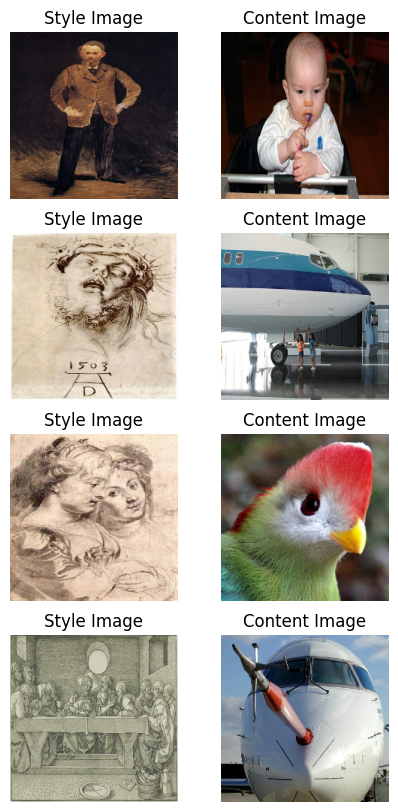

In [5]:
style, content = next(iter(train_ds))
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(5, 10))
[ax.axis("off") for ax in np.ravel(axes)]

for (axis, style_image, content_image) in zip(axes, style[0:4], content[0:4]):
    (ax_style, ax_content) = axis
    ax_style.imshow(style_image)
    ax_style.set_title("Style Image")

    ax_content.imshow(content_image)
    ax_content.set_title("Content Image")

## Model Building

In [6]:
def get_encoder():
    vgg19 = keras.applications.VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(*IMAGE_SIZE, 3),
    )
    vgg19.trainable = False
    mini_vgg19 = keras.Model(vgg19.input, vgg19.get_layer("block4_conv1").output)

    inputs = layers.Input([*IMAGE_SIZE, 3])
    mini_vgg19_out = mini_vgg19(inputs)
    return keras.Model(inputs, mini_vgg19_out)

In [7]:
def get_mean_std(x, epsilon=1e-5):
    axes = [1, 2]

    # Compute the mean and standard deviation of a tensor.
    mean, variance = tf.nn.moments(x, axes=axes, keepdims=True)
    standard_deviation = tf.sqrt(variance + epsilon)
    return mean, standard_deviation


def ada_in(style, content):
    """Computes the AdaIn feature map.

    Args:
        style: The style feature map.
        content: The content feature map.

    Returns:
        The AdaIN feature map.
    """
    content_mean, content_std = get_mean_std(content)
    style_mean, style_std = get_mean_std(style)
    t = style_std * (content - content_mean) / content_std + style_mean
    return t

In [8]:
def get_decoder():
    config = {"kernel_size": 3, "strides": 1, "padding": "same", "activation": "relu"}
    decoder = keras.Sequential(
        [
            layers.InputLayer((None, None, 512)),
            layers.Conv2D(filters=512, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=128, **config),
            layers.Conv2D(filters=128, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=64, **config),
            layers.Conv2D(
                filters=3,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="sigmoid",
            ),
        ]
    )
    return decoder

In [9]:
def get_loss_net():
    vgg19 = keras.applications.VGG19(
        include_top=False, weights="imagenet", input_shape=(*IMAGE_SIZE, 3)
    )
    vgg19.trainable = False
    layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]
    outputs = [vgg19.get_layer(name).output for name in layer_names]
    mini_vgg19 = keras.Model(vgg19.input, outputs)

    inputs = layers.Input([*IMAGE_SIZE, 3])
    mini_vgg19_out = mini_vgg19(inputs)
    return keras.Model(inputs, mini_vgg19_out, name="loss_net")


In [10]:
class NeuralStyleTransfer(tf.keras.Model):
    def __init__(self, encoder, decoder, loss_net, style_weight, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_net = loss_net
        self.style_weight = style_weight

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.style_loss_tracker = keras.metrics.Mean(name="style_loss")
        self.content_loss_tracker = keras.metrics.Mean(name="content_loss")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, inputs):
        style, content = inputs

        # Initialize the content and style loss.
        loss_content = 0.0
        loss_style = 0.0

        with tf.GradientTape() as tape:
            # Encode the style and content image
            style_encoder = self.encoder(style)
            content_encoder = self.encoder(content)

            # Compute the AdaIN target feature maps
            t = ada_in(style_encoder, content_encoder)

            # Generate the neural style transferred image
            reconstructed_image = self.decoder(t)

            # Compute image features for style loss
            reconstructed_features = self.loss_net(reconstructed_image)
            style_features = self.loss_net(style)

            # Compute style loss
            for inp, out in zip(style_features, reconstructed_features):
                mean_inp, std_inp = get_mean_std(inp)
                mean_out, std_out = get_mean_std(out)

                loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(std_inp, std_out)

            # Compute total loss
            loss_content = self.loss_fn(t, reconstructed_features[-1])

            total_loss = loss_content + self.style_weight*loss_style

        # Compute gradients and optimize the decoder.
        trainable_vars = self.decoder.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the trackers.
        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(loss_content)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def test_step(self, inputs):
        style, content = inputs

        # Initialize the content and style loss.
        loss_content = 0.0
        loss_style = 0.0

        # Encode the style and content image
        style_encoder = self.encoder(style)
        content_encoder = self.encoder(content)

        # Compute the AdaIN target feature maps
        t = ada_in(style_encoder, content_encoder)

        # Generate the neural style transferred image
        reconstructed_image = self.decoder(t)

        # Compute image features for style loss
        reconstructed_features = self.loss_net(reconstructed_image)
        style_features = self.loss_net(style)

        # Compute style loss
        for inp, out in zip(style_features, reconstructed_features):
            mean_inp, std_inp = get_mean_std(inp)
            mean_out, std_out = get_mean_std(out)

            loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(std_inp, std_out)

        # Compute total loss
        loss_content = self.loss_fn(t, reconstructed_features[-1])

        total_loss = loss_content + self.style_weight*loss_style

        # Update the trackers.
        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(loss_content)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    @property
    def metrics(self):
        return [
            self.style_loss_tracker,
            self.content_loss_tracker,
            self.total_loss_tracker,
        ]

## Model Training

In [13]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = keras.losses.MeanSquaredError()

encoder = get_encoder()
loss_net = get_loss_net()
decoder = get_decoder()

model = NeuralStyleTransfer(
    encoder=encoder, decoder=decoder, loss_net=loss_net, style_weight=100
)

model.compile(optimizer=optimizer, loss_fn=loss_fn)

history = model.fit(
    train_ds,
    epochs=200,
    steps_per_epoch=50,
    validation_data=val_ds,
    validation_steps=50,
)

Epoch 1/200
50/50 [==============================] - 19s 279ms/step - style_loss: 52.7709 - content_loss: 166.2099 - total_loss: 5443.3027 - val_style_loss: 33.7041 - val_content_loss: 150.7745 - val_total_loss: 3521.1812
Epoch 2/200
50/50 [==============================] - 13s 269ms/step - style_loss: 24.9103 - content_loss: 144.1605 - total_loss: 2635.1960 - val_style_loss: 18.4368 - val_content_loss: 128.6081 - val_total_loss: 1972.2913
Epoch 3/200
50/50 [==============================] - 13s 269ms/step - style_loss: 15.0999 - content_loss: 132.7737 - total_loss: 1642.7621 - val_style_loss: 13.1095 - val_content_loss: 124.0812 - val_total_loss: 1435.0267
Epoch 4/200
50/50 [==============================] - 13s 268ms/step - style_loss: 11.5110 - content_loss: 130.9403 - total_loss: 1282.0453 - val_style_loss: 10.1869 - val_content_loss: 131.9249 - val_total_loss: 1150.6193
Epoch 5/200
50/50 [==============================] - 13s 269ms/step - style_loss: 9.8620 - content_loss: 130.475

## Results

In [14]:
def stylize_image(content, style, alpha=0):
    style_encoded = model.encoder(style)
    content_encoded = model.encoder(content)
    t = ada_in(style=style_encoded, content=content_encoded)

    t = alpha*t + (1-alpha)*content_encoded

    reconstructed_image = model.decoder(t)

    return reconstructed_image

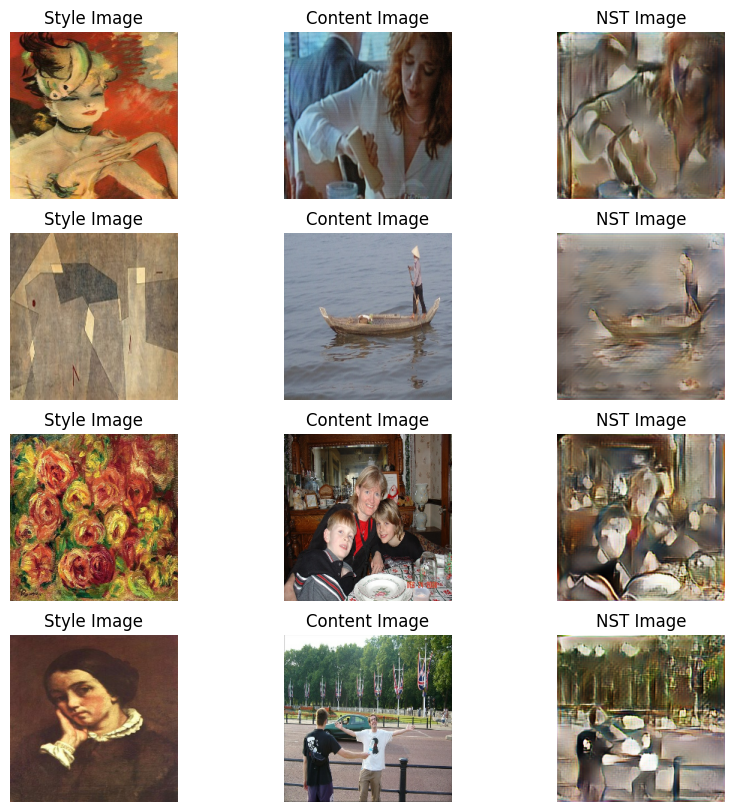

In [15]:
for style, content in test_ds.take(1):
    reconstructed_image = stylize_image(content, style)
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))
    [ax.axis("off") for ax in np.ravel(axes)]

    for axis, style_image, content_image, reconstructed_image in zip(
        axes, style[0:4], content[0:4], reconstructed_image[0:4]
    ):
        (ax_style, ax_content, ax_reconstructed) = axis
        ax_style.imshow(style_image)
        ax_style.set_title("Style Image")
        ax_content.imshow(content_image)
        ax_content.set_title("Content Image")
        ax_reconstructed.imshow(reconstructed_image)
        ax_reconstructed.set_title("NST Image")

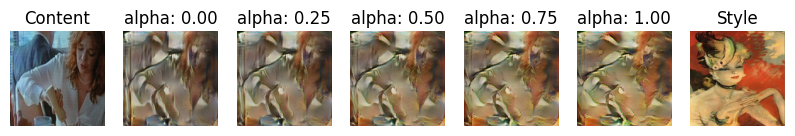

In [16]:
for style, content in test_ds.take(1):
    reconstructed_image = stylize_image(content, style)

    style_image = style[0]
    content_image = content[0]
    reconstructed_image = reconstructed_image[0]

    alphas = np.linspace(0, 1, 5, endpoint=True)
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(10, 5))
    [ax.axis("off") for ax in np.ravel(axes)]

    axes[0].imshow(content_image)
    axes[0].set_title("Content")

    axes[-1].imshow(style_image)
    axes[-1].set_title("Style")

    for ax, alpha in zip(axes[1:-1], alphas):
        image = stylize_image(content, style, alpha)[0]

        ax.imshow(image)
        ax.set_title(f"alpha: {alpha:.2f}")

In [ ]:
model.save_weights("model_weights.h5")